# Fairness policies with continuous-single traces

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware LAS, FIFO, and FTF policies, with and without space sharing, on traces with single-GPU and multi-GPU jobs.

## Import statements

In [1]:
from plotting_utils import plot_metric_vs_inverse_lambda, plot_jct_cdf
from utils import get_logfile_paths, average_jct_fn

## Get list of relevant logfiles and define label mapping

In [2]:
logfile_paths = sorted(get_logfile_paths(
    "/future/u/deepakn/gavel/logs/multi_gpu_continuous_jobs_final/"))

In [3]:
labels = {"allox": "AlloX",
          "gandiva": "LAS w/ Gandiva SS",
          "fifo": "FIFO",
          "fifo_perf": "Gavel",
          "fifo_packed": "Gavel w/ SS",
          "finish_time_fairness": "FTF",
          "finish_time_fairness_perf": "Gavel",
          "max_min_fairness": "LAS",
          "max_min_fairness_perf": "Gavel",
          "max_min_fairness_packed": "Gavel w/ SS"}

## Plot average JCT versus input job rate

['fifo', 'fifo_perf', 'fifo_packed']
('FIFO', 0.2)
input_job_rate     0.200000
metric            17.294259
seed               1.000000
dtype: float64
('FIFO', 0.4)
input_job_rate     0.400000
metric            17.325454
seed               1.000000
dtype: float64
('FIFO', 0.6)
input_job_rate     0.6000
metric            17.5529
seed               1.0000
dtype: float64
('FIFO', 0.8)
input_job_rate     0.80000
metric            17.84437
seed               1.00000
dtype: float64
('FIFO', 1.0)
input_job_rate     1.000000
metric            18.363202
seed               1.000000
dtype: float64
('FIFO', 1.2)
input_job_rate     1.200000
metric            19.255351
seed               1.000000
dtype: float64
('FIFO', 1.4000000002333335)
input_job_rate     1.400000
metric            20.520807
seed               1.000000
dtype: float64
('FIFO', 1.6)
input_job_rate     1.600000
metric            25.458994
seed               1.000000
dtype: float64
('FIFO', 1.8)
input_job_rate     1.800000
metric     

/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:79: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


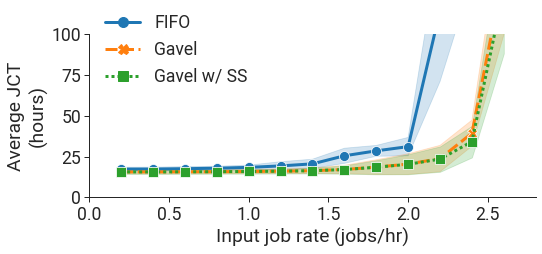

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
('Gavel', 0.2)
input_job_rate     0.200000
metric            17.291212
seed               1.000000
dtype: float64
('Gavel', 0.4)
input_job_rate     0.400000
metric            17.312775
seed               1.000000
dtype: float64
('Gavel', 0.6)
input_job_rate     0.600000
metric            17.331529
seed               1.000000
dtype: float64
('Gavel', 0.8)
input_job_rate     0.800000
metric            17.274679
seed               1.000000
dtype: float64
('Gavel', 1.0)
input_job_rate     1.000000
metric            17.216846
seed               1.000000
dtype: float64
('Gavel', 1.2)
input_job_rate     1.200000
metric            17.086312
seed               1.000000
dtype: float64
('Gavel', 1.4000000002333335)
input_job_rate     1.400000
metric            17.021867
seed               1.000000
dtype: float64
('Gavel', 1.6)
input_job_rate     1.600000
metric            17.192634
seed               1.000000
dtyp

/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:79: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


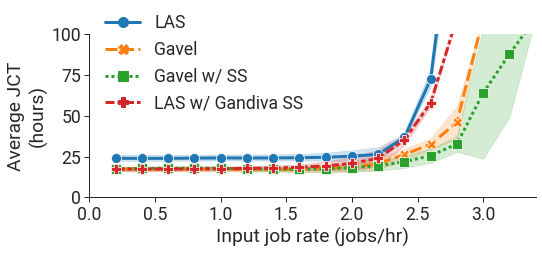

['finish_time_fairness', 'finish_time_fairness_perf']
('FTF', 0.2)
input_job_rate     0.200000
metric            23.913384
seed               1.000000
dtype: float64
('FTF', 0.4)
input_job_rate     0.400000
metric            23.867195
seed               1.000000
dtype: float64
('FTF', 0.6)
input_job_rate     0.600000
metric            23.898508
seed               1.000000
dtype: float64
('FTF', 0.8)
input_job_rate     0.800000
metric            24.009824
seed               1.000000
dtype: float64
('FTF', 1.0)
input_job_rate     1.00000
metric            24.16896
seed               1.00000
dtype: float64
('FTF', 1.2)
input_job_rate     1.200000
metric            24.102059
seed               1.000000
dtype: float64
('FTF', 1.4000000002333335)
input_job_rate     1.400000
metric            24.134485
seed               1.000000
dtype: float64
('FTF', 1.6)
input_job_rate     1.60000
metric            24.25566
seed               1.00000
dtype: float64
('FTF', 1.8)
input_job_rate     1.800000


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:79: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


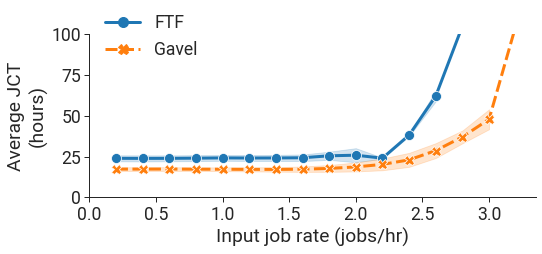

In [4]:
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    xmax=2.8,
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/multi_gpu_fifo_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    xmax=3.4,
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/multi_gpu_las_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/multi_gpu_ftf_v100=36_p100=36_k80=36.pdf"
)

## Plot CDFs of JCT and FTF

['fifo', 'fifo_perf', 'fifo_packed']
Input job rate: 0.20
fifo: 18.56
fifo_perf: 16.91
fifo_packed: 16.91


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


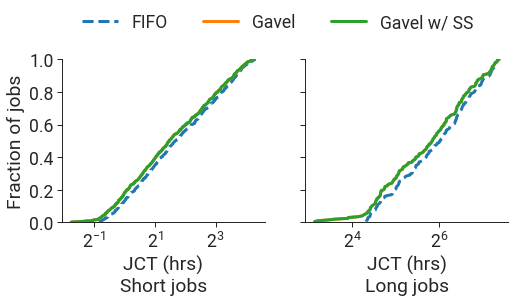

Input job rate: 0.40
fifo: 18.61
fifo_perf: 16.96
fifo_packed: 16.96


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


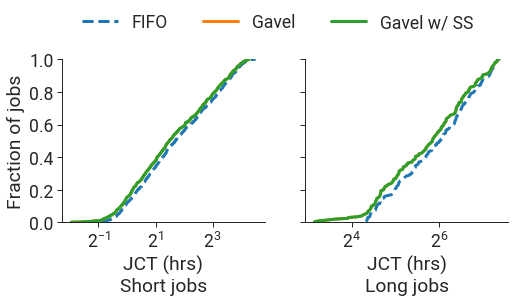

Input job rate: 0.60
fifo: 18.95
fifo_perf: 17.01
fifo_packed: 17.01


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


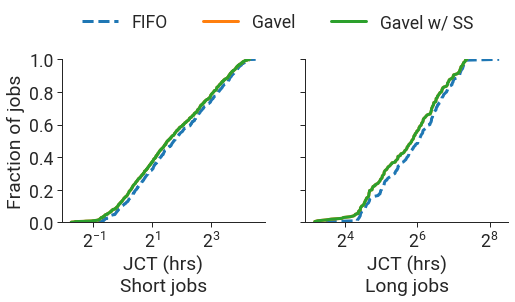

Input job rate: 0.80
fifo: 19.21
fifo_perf: 17.10
fifo_packed: 17.10


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


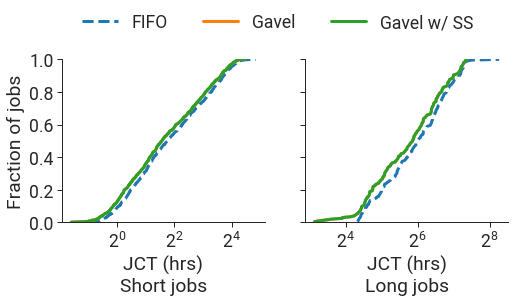

Input job rate: 1.00
fifo: 19.92
fifo_perf: 17.34
fifo_packed: 17.34


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


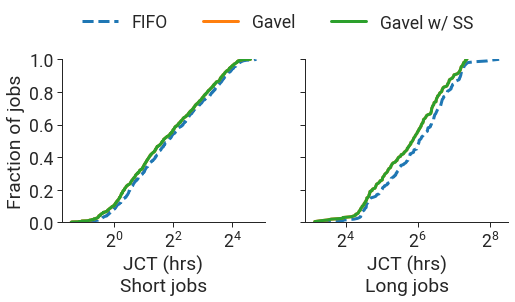

Input job rate: 1.20
fifo: 22.20
fifo_perf: 17.65
fifo_packed: 17.65


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


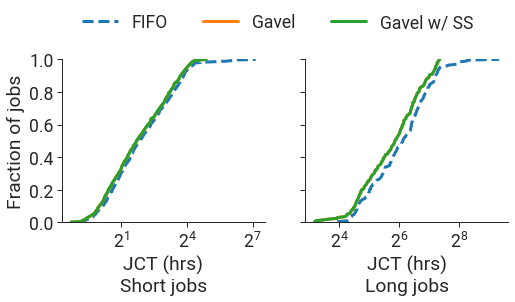

Input job rate: 1.40
fifo: 23.70
fifo_perf: 18.29
fifo_packed: 18.29


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


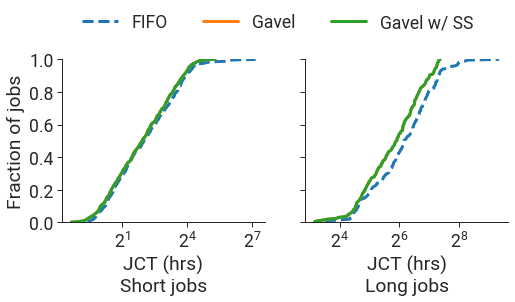

Input job rate: 1.60
fifo: 30.82
fifo_perf: 20.02
fifo_packed: 19.95


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


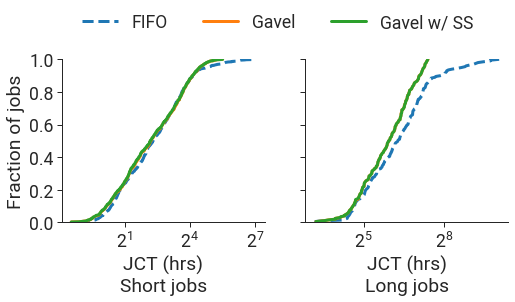

Input job rate: 1.80
fifo: 31.54
fifo_perf: 23.71
fifo_packed: 23.44


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


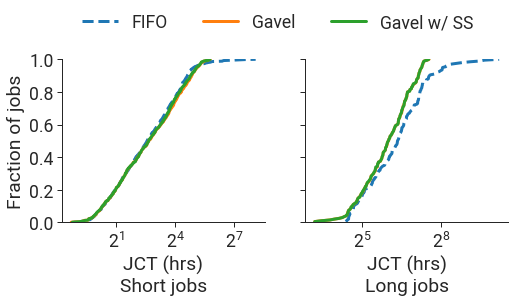

Input job rate: 2.00
fifo: 37.56
fifo_perf: 27.68
fifo_packed: 27.34


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


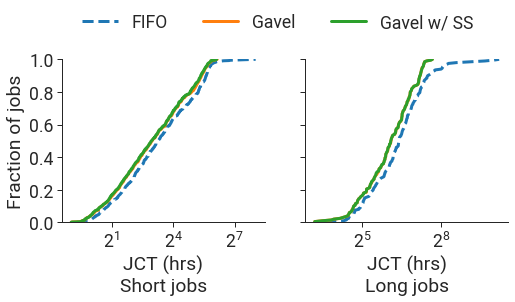

Input job rate: 2.20
fifo: 65.45
fifo_perf: 33.05
fifo_packed: 32.37


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


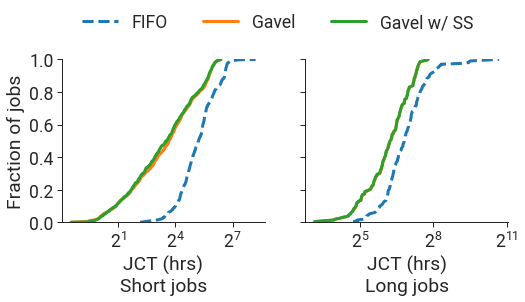

Input job rate: 2.40
fifo: 129.27
fifo_perf: 43.94
fifo_packed: 42.34


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


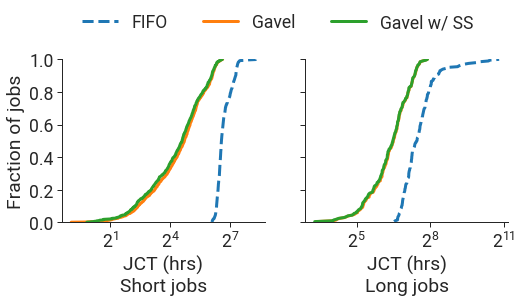

Input job rate: 2.60
fifo: 304.76
fifo_perf: 93.60
fifo_packed: 82.18


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


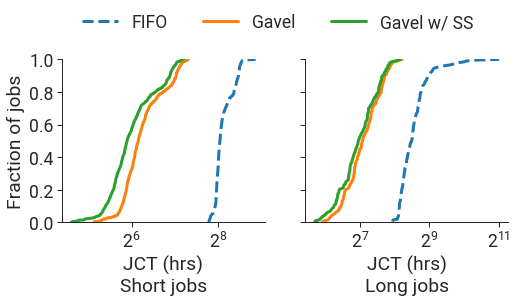

Input job rate: 2.80
fifo: 414.68
fifo_perf: 204.44


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


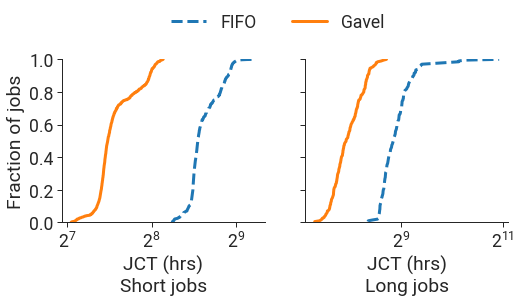

Input job rate: 3.00
fifo: 537.18
fifo_perf: 301.75


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


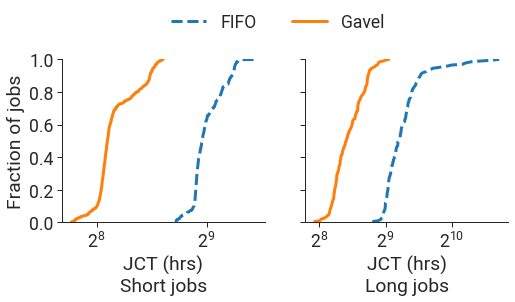

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.20
max_min_fairness: 25.93
max_min_fairness_perf: 18.55
max_min_fairness_packed: 18.72
gandiva: 18.55


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


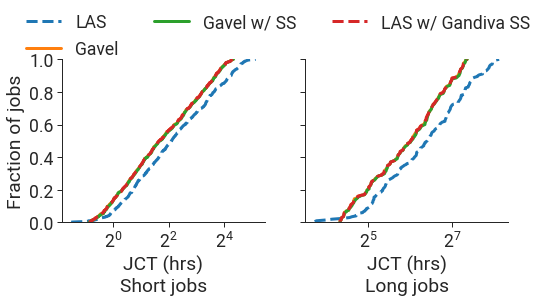

Input job rate: 0.40
max_min_fairness: 25.92
max_min_fairness_perf: 18.58
max_min_fairness_packed: 18.95
gandiva: 18.59


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


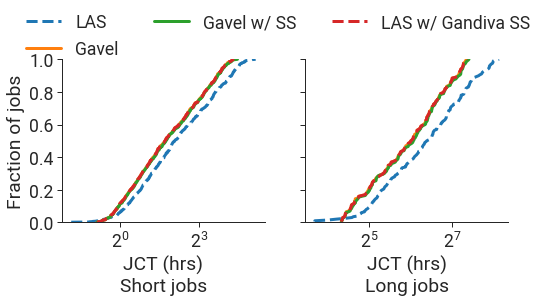

Input job rate: 0.60
max_min_fairness: 25.88
max_min_fairness_perf: 18.59
max_min_fairness_packed: 19.09
gandiva: 18.66


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


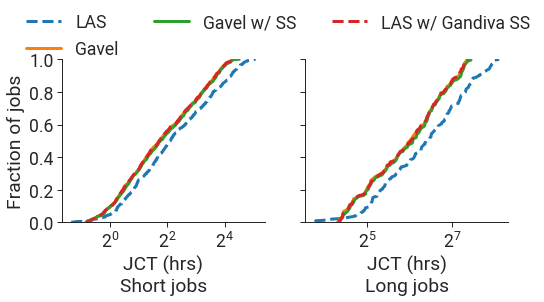

Input job rate: 0.80
max_min_fairness: 26.08
max_min_fairness_perf: 18.51
max_min_fairness_packed: 18.98
gandiva: 18.76


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


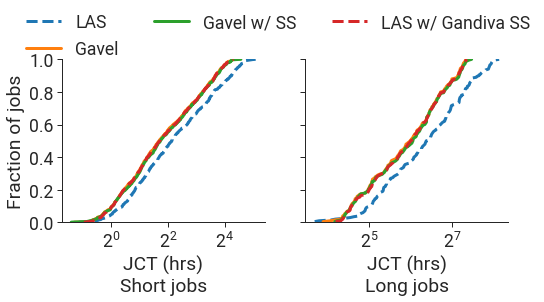

Input job rate: 1.00
max_min_fairness: 26.10
max_min_fairness_perf: 18.54
max_min_fairness_packed: 19.01
gandiva: 18.96


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


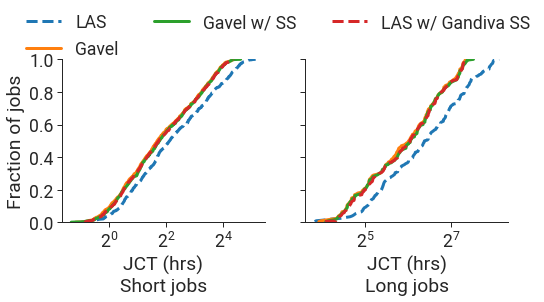

Input job rate: 1.20
max_min_fairness: 26.10
max_min_fairness_perf: 18.49
max_min_fairness_packed: 18.78
gandiva: 19.23


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


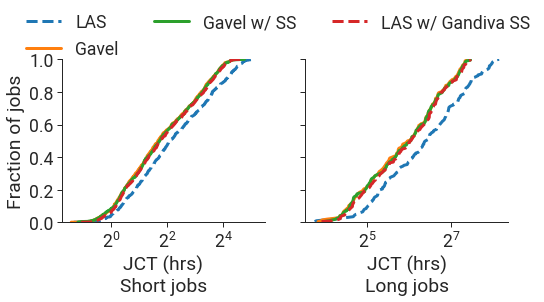

Input job rate: 1.40
max_min_fairness: 26.23
max_min_fairness_perf: 18.55
max_min_fairness_packed: 18.68
gandiva: 19.58


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


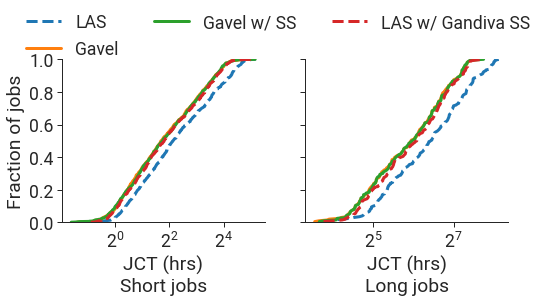

Input job rate: 1.60
max_min_fairness: 26.51
max_min_fairness_perf: 19.12
max_min_fairness_packed: 18.90
gandiva: 20.47


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


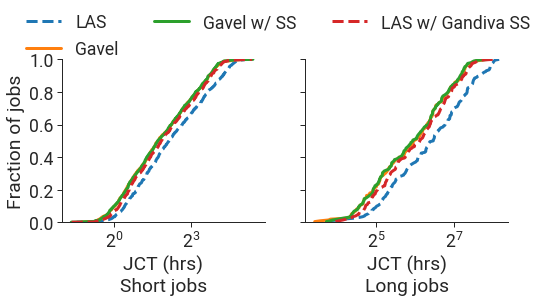

Input job rate: 1.80
max_min_fairness: 27.29
max_min_fairness_perf: 20.35
max_min_fairness_packed: 19.66
gandiva: 22.32


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


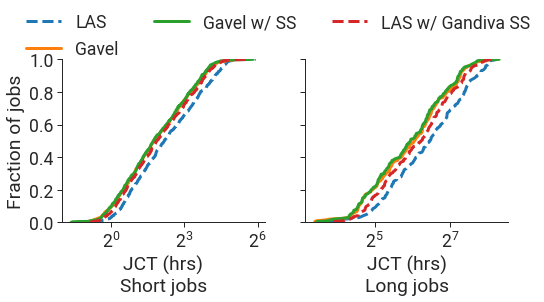

Input job rate: 2.00
max_min_fairness: 28.91
max_min_fairness_perf: 21.90
max_min_fairness_packed: 20.85
gandiva: 25.16


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


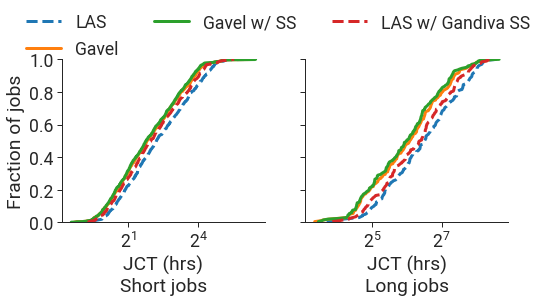

Input job rate: 2.20
max_min_fairness: 30.82
max_min_fairness_perf: 24.61
max_min_fairness_packed: 22.89
gandiva: 30.02


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


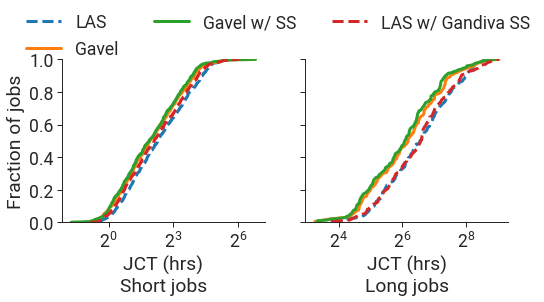

Input job rate: 2.40
max_min_fairness: 38.71
max_min_fairness_perf: 30.03
max_min_fairness_packed: 26.22
gandiva: 38.79


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


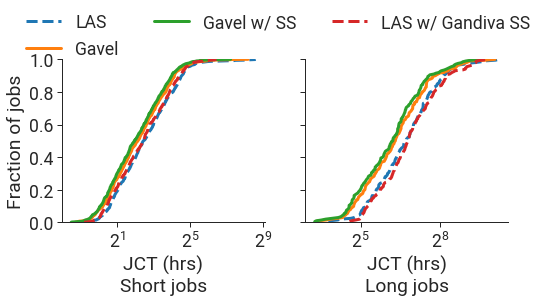

Input job rate: 2.60
max_min_fairness: 70.54
max_min_fairness_perf: 36.44
max_min_fairness_packed: 30.51
gandiva: 60.43


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


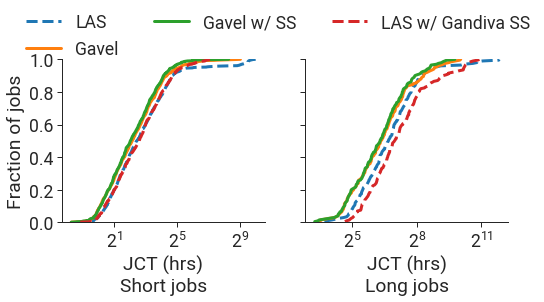

Input job rate: 2.80
max_min_fairness: 169.93
max_min_fairness_perf: 55.78
max_min_fairness_packed: 38.25


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


gandiva: nan


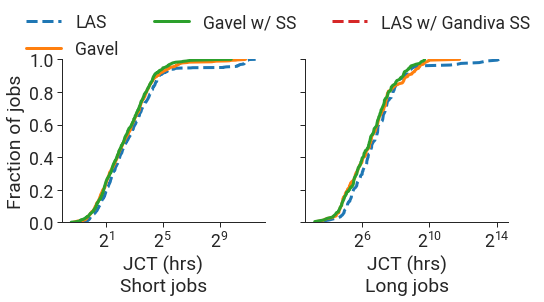

Input job rate: 3.00


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


max_min_fairness_perf: nan
max_min_fairness_packed: 46.94


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


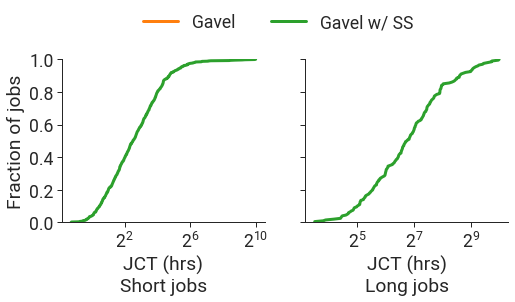

['finish_time_fairness', 'finish_time_fairness_perf']
Input job rate: 0.20
finish_time_fairness: 25.93
finish_time_fairness_perf: 18.55


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


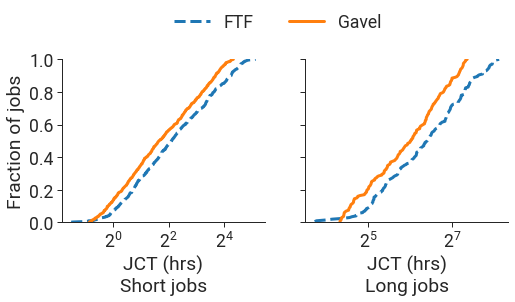

Input job rate: 0.40
finish_time_fairness: 25.92
finish_time_fairness_perf: 18.57


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


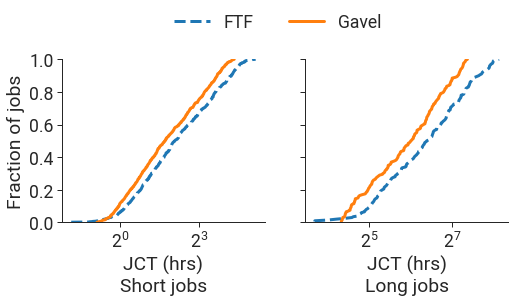

Input job rate: 0.60
finish_time_fairness: 25.89
finish_time_fairness_perf: 18.58


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


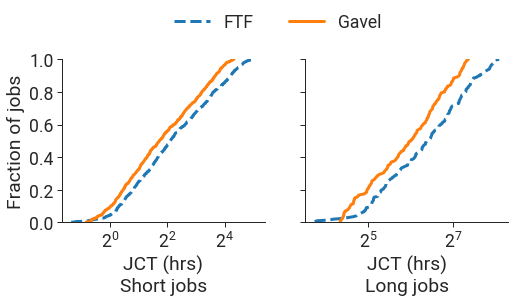

Input job rate: 0.80
finish_time_fairness: 26.06
finish_time_fairness_perf: 18.46


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


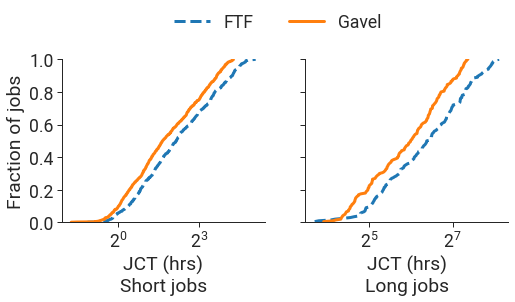

Input job rate: 1.00
finish_time_fairness: 26.12
finish_time_fairness_perf: 18.51


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


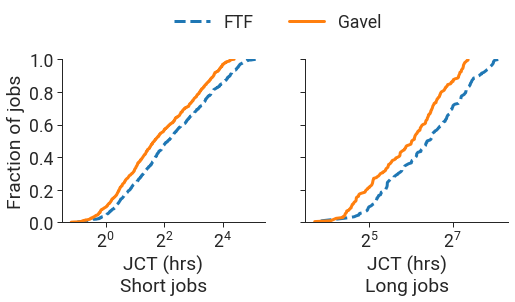

Input job rate: 1.20
finish_time_fairness: 26.12
finish_time_fairness_perf: 18.55


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


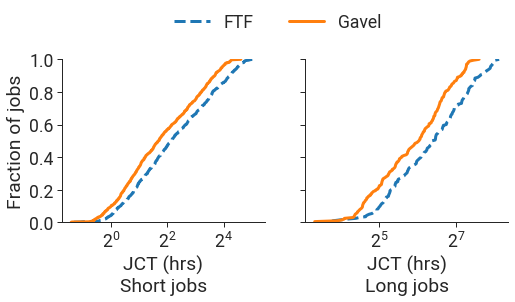

Input job rate: 1.40
finish_time_fairness: 26.24
finish_time_fairness_perf: 18.67


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


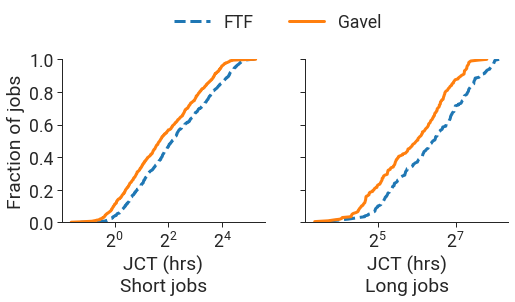

Input job rate: 1.60
finish_time_fairness: 26.50
finish_time_fairness_perf: 19.14


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


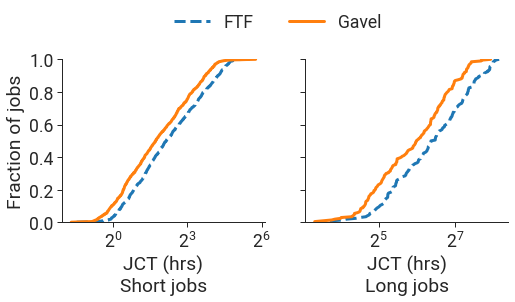

Input job rate: 1.80
finish_time_fairness: 27.23
finish_time_fairness_perf: 20.12


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


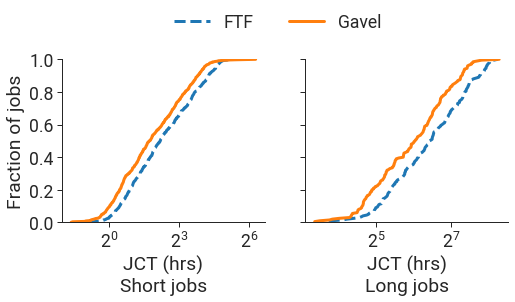

Input job rate: 2.00
finish_time_fairness: 28.87
finish_time_fairness_perf: 21.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


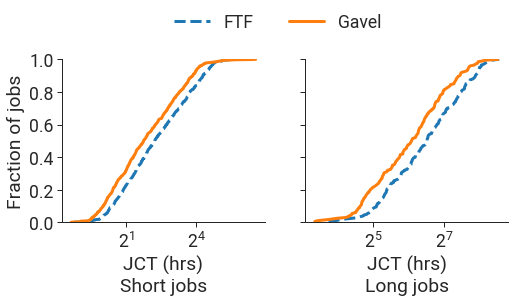

Input job rate: 2.20
finish_time_fairness_perf: 24.36


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


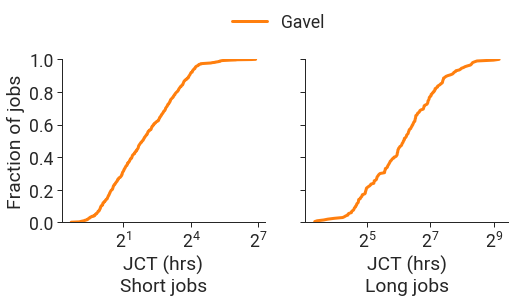

Input job rate: 2.40
finish_time_fairness: 38.65
finish_time_fairness_perf: 27.93


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


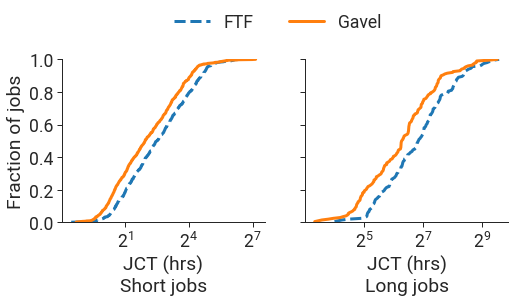

Input job rate: 2.60
finish_time_fairness: 64.38
finish_time_fairness_perf: 33.90


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


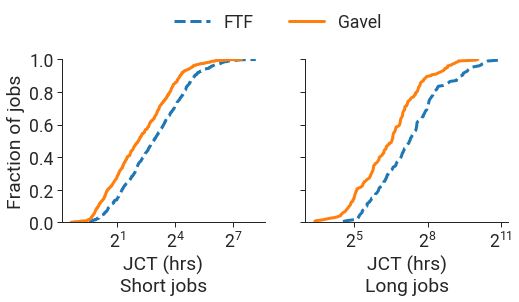

Input job rate: 2.80
finish_time_fairness_perf: 41.56


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


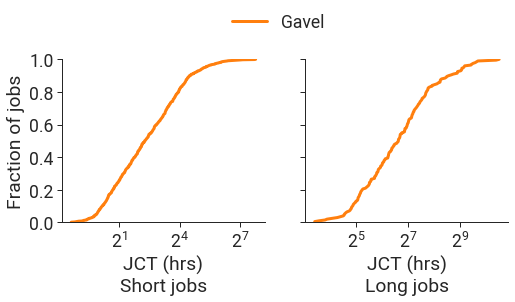

Input job rate: 3.00
finish_time_fairness_perf: 52.19


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


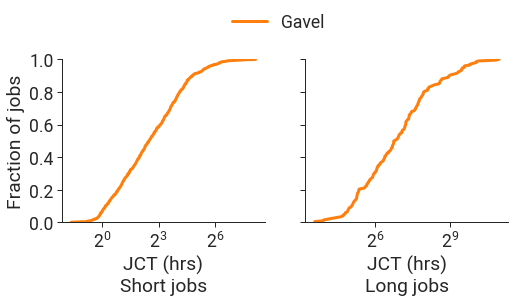

In [5]:
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_fifo_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_ftf_v100=36_p100=36_k80=36/"
)

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.82
gandiva: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


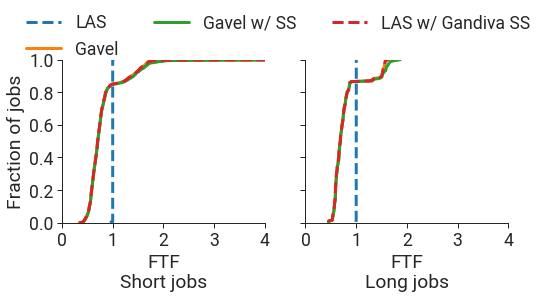

Input job rate: 0.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.83
gandiva: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


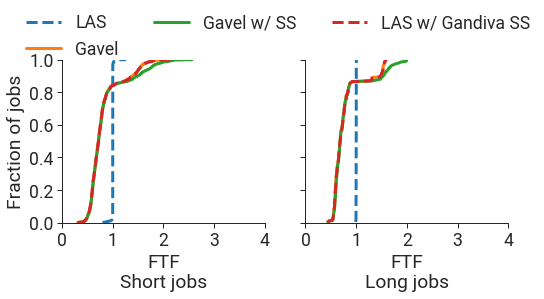

Input job rate: 0.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.84
gandiva: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


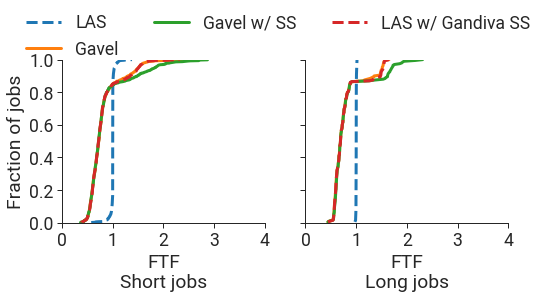

Input job rate: 0.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.82
gandiva: 0.79


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


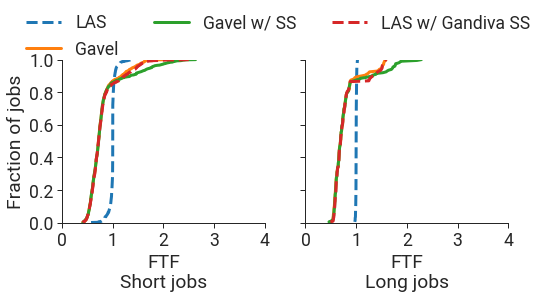

Input job rate: 1.00
max_min_fairness: 1.01
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.82
gandiva: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


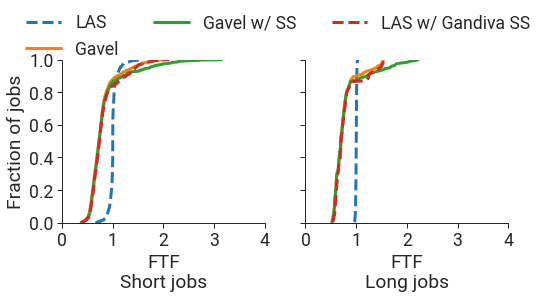

Input job rate: 1.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.76
max_min_fairness_packed: 0.79
gandiva: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


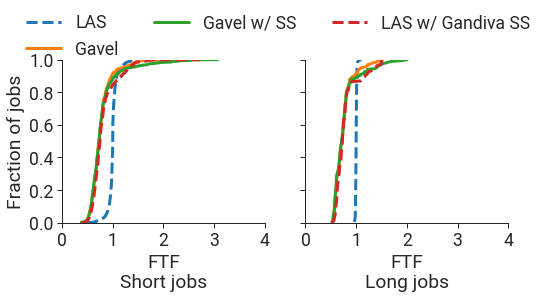

Input job rate: 1.40
max_min_fairness: 1.01
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.77
gandiva: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


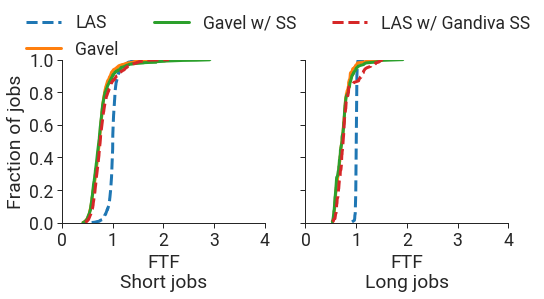

Input job rate: 1.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.76
max_min_fairness_packed: 0.75
gandiva: 0.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


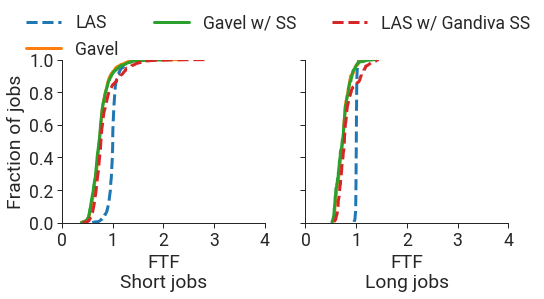

Input job rate: 1.80
max_min_fairness: 1.01
max_min_fairness_perf: 0.77
max_min_fairness_packed: 0.75
gandiva: 0.86


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


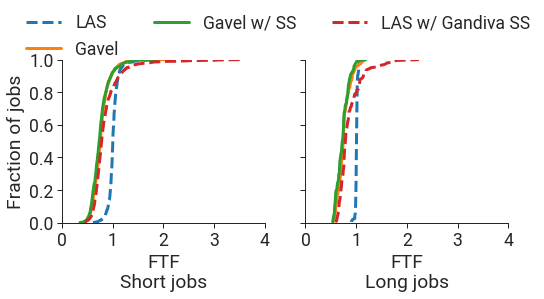

Input job rate: 2.00
max_min_fairness: 1.03
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.76
gandiva: 0.92


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


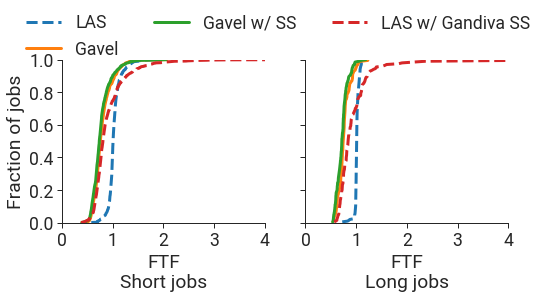

Input job rate: 2.20
max_min_fairness: 1.02
max_min_fairness_perf: 0.82
max_min_fairness_packed: 0.78
gandiva: 0.98


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


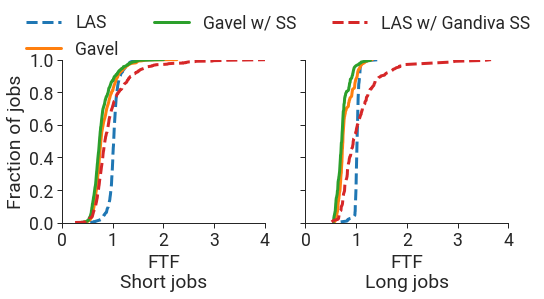

Input job rate: 2.40
max_min_fairness: 1.10
max_min_fairness_perf: 0.85
max_min_fairness_packed: 0.76
gandiva: 1.09


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


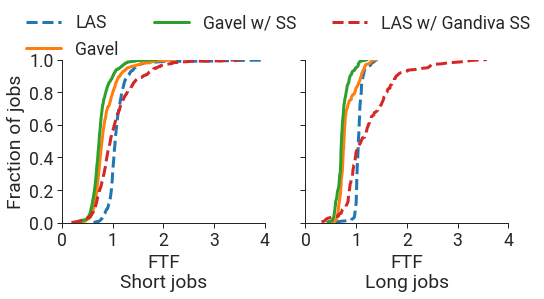

Input job rate: 2.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.81
max_min_fairness_packed: 0.76
gandiva: 1.23


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


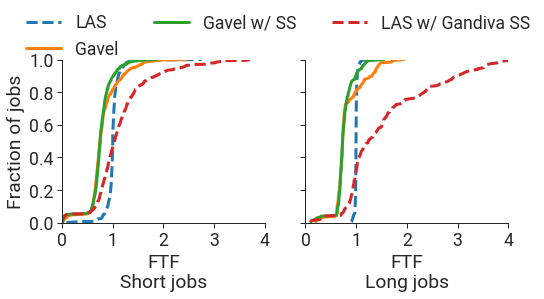

Input job rate: 2.80
max_min_fairness: 1.02
max_min_fairness_perf: 0.91
max_min_fairness_packed: 0.86


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


gandiva: nan


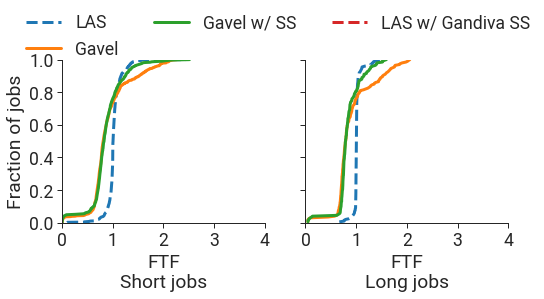

Input job rate: 3.00
['finish_time_fairness', 'finish_time_fairness_perf']
Input job rate: 0.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


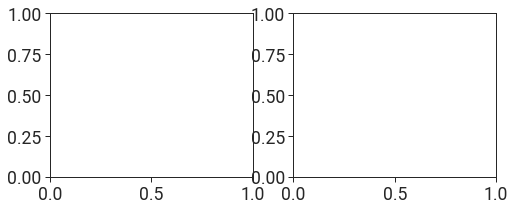

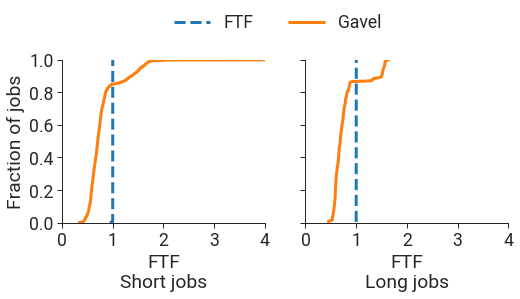

Input job rate: 0.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


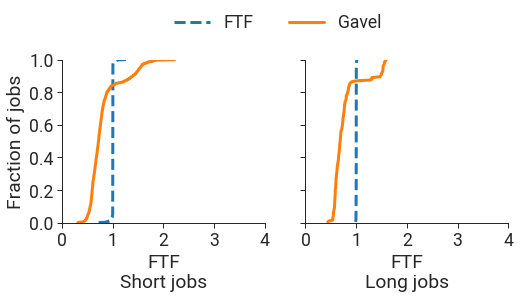

Input job rate: 0.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


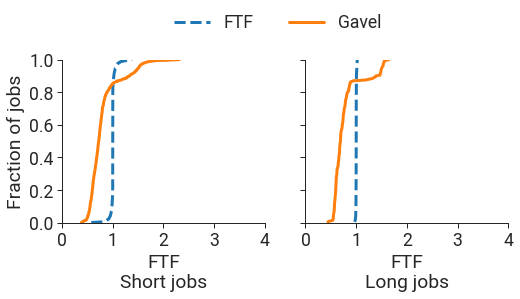

Input job rate: 0.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


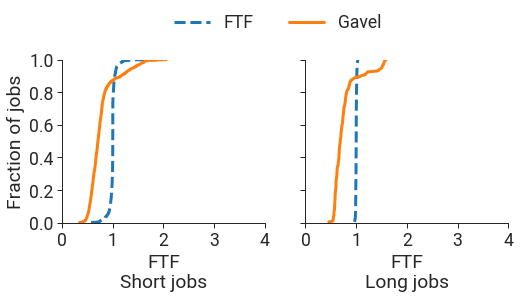

Input job rate: 1.00
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


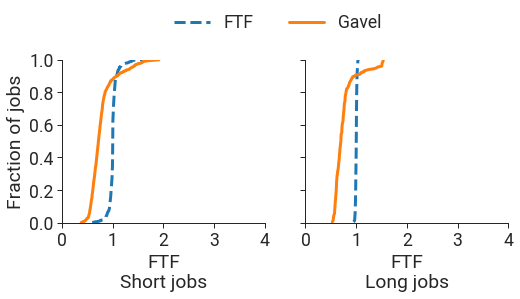

Input job rate: 1.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.76


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


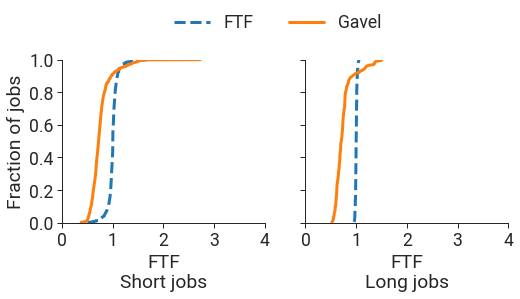

Input job rate: 1.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.74


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


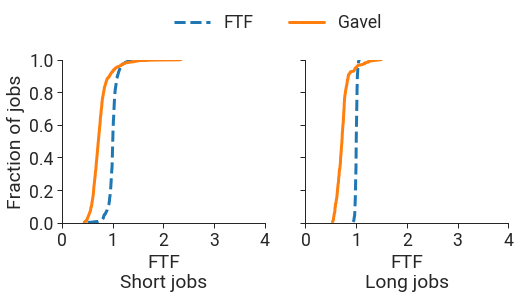

Input job rate: 1.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.75


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


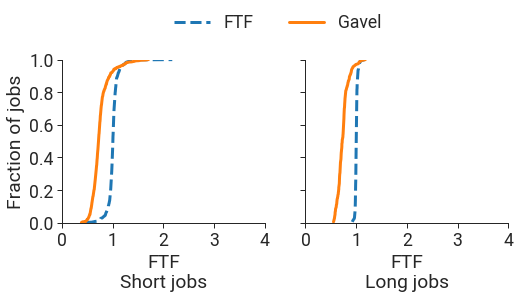

Input job rate: 1.80
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.75


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


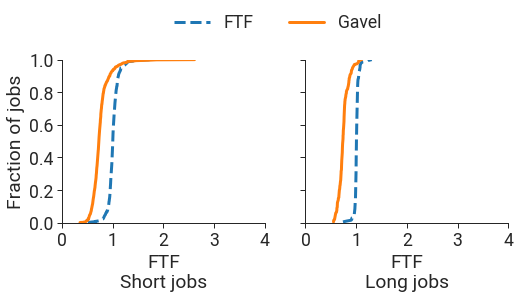

Input job rate: 2.00
finish_time_fairness: 1.02
finish_time_fairness_perf: 0.76


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


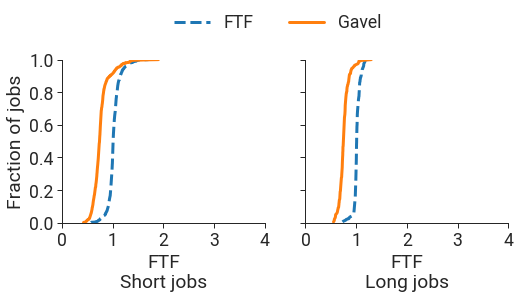

Input job rate: 2.20
finish_time_fairness_perf: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


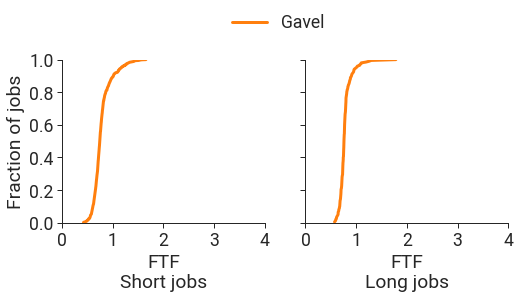

Input job rate: 2.40
finish_time_fairness: 1.12
finish_time_fairness_perf: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


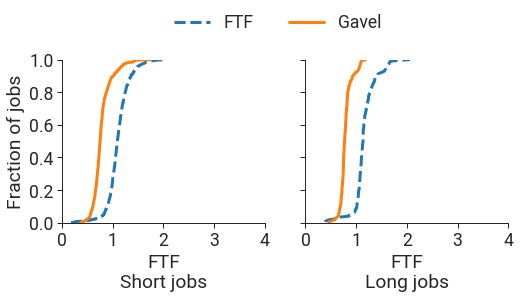

Input job rate: 2.60
finish_time_fairness: 1.40
finish_time_fairness_perf: 0.79


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


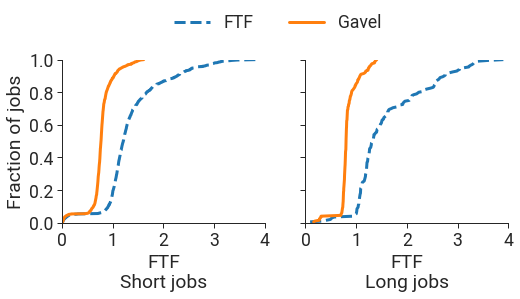

Input job rate: 2.80
finish_time_fairness_perf: 0.86


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:194: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


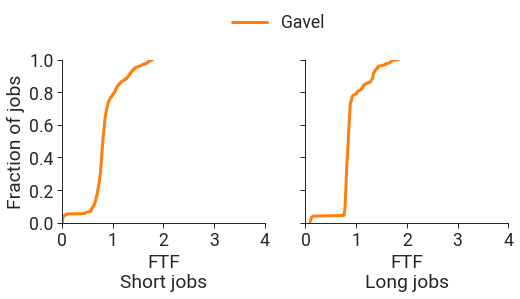

Input job rate: 3.00


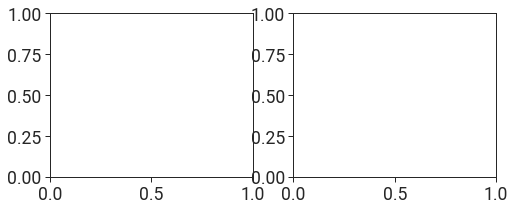

In [6]:
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/multi_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/multi_gpu_ftf_v100=36_p100=36_k80=36/"
)